<a href="https://colab.research.google.com/github/jgrandinetti/AI/blob/master/FlowerRecog_NoImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Dependencies
import numpy as np
import pandas as pd
from keras import layers
from keras import models, Model
from keras import backend as K
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
from pathlib import Path
import cv2
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from keras.applications import VGG16, DenseNet121
from keras.callbacks import EarlyStopping
from tqdm import tqdm

Using TensorFlow backend.


In [0]:
!pip install kaggle

# Kaggle API Token
from google.colab import files
files.upload()

In [0]:
# File Config for Kaggle Data
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#Download Kaggle Dataset
!kaggle datasets download -d alxmamaev/flowers-recognition

!unzip flowers-recognition.zip

!rm /content/flowers/dandelion/run_me.py

In [5]:
data_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,height_shift_range=0.2, validation_split=0.2)

img_size = 224
batch_size = 20
t_steps = 3462/batch_size
v_steps = 861/batch_size

train_gen = data_gen.flow_from_directory('flowers', target_size = (img_size, img_size), batch_size = batch_size, class_mode='categorical', subset='training')
valid_gen = data_gen.flow_from_directory('flowers', target_size = (img_size, img_size), batch_size = batch_size, class_mode ='categorical', subset='validation')

train_labels = train_gen.class_indices
valid_labels = valid_gen.class_indices

print("-------------------------")
print("Training Labels")
print(train_labels)
print()
print("Validation Labels")
print(valid_labels)
print("-------------------------")

Found 3462 images belonging to 5 classes.
Found 861 images belonging to 5 classes.
-------------------------
Training Labels
{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

Validation Labels
{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
-------------------------


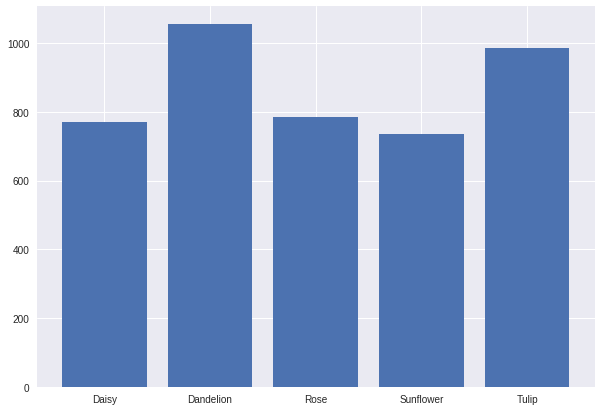

In [9]:
flower_size = []
daisy_size = len(os.listdir('/content/flowers/daisy'))
dandelion_size = len(os.listdir('/content/flowers/dandelion'))
rose_size = len(os.listdir('/content/flowers/rose'))
sun_size = len(os.listdir('/content/flowers/sunflower'))
tulip_size = len(os.listdir('/content/flowers/tulip'))

flower_size = [daisy_size, dandelion_size, rose_size, sun_size, tulip_size]
flower_name = ('Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip')
y = np.arange(len(flower_name))

plt.figure(0, figsize=(10, 7))
plt.bar(y, flower_size)
plt.xticks(y,flower_name)
plt.show()

In [0]:
# Model from scratch

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size,img_size,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# model.summary()

In [0]:
# VGG16 Model

conv_base = VGG16(include_top=False, weights='imagenet', input_shape=(img_size,img_size,3))
conv_base.trainable = False

x = (layers.Flatten())(conv_base.output)
x = (layers.Dense(256, activation='relu'))(x)
x = (layers.Dropout(0.2))(x)
x = (layers.Dense(5, activation='softmax'))(x)

model2 = Model(inputs=conv_base.input, outputs = x)

optimizer = Adam(lr=0.0001)
# optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.1,)

model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.5, patience=5, verbose=1, mode='auto')

# model2.summary()

In [0]:
K.set_image_dim_ordering('tf')

dnet = DenseNet121(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
dnet.trainable=False

x = dnet.output
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.3)(x)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.3)(x)
# x = layers.Dense(128, activation='relu')(x)
# x = layers.Dropout(0.3)(x)
x = (layers.Flatten())(x)
x = (layers.Dense(256, activation='relu'))(x)
x = (layers.Dropout(0.2))(x)
x = layers.Dense(5, activation='softmax')(x)
model3 = Model(input=dnet.input, output=x)

optimizer = Adam(lr=0.0001)
# optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.1,)

model3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# model3.summary()

In [0]:
# From Scratch
model_hist = model.fit_generator(train_gen, steps_per_epoch=t_steps, epochs=50, validation_data=valid_gen, validation_steps=v_steps)

# VGG16
model_hist2 = model2.fit_generator(train_gen, steps_per_epoch=t_steps, epochs=15, validation_data=valid_gen, validation_steps=v_steps)

# DenseNet121
model_hist3 = model3.fit_generator(train_gen, steps_per_epoch=t_steps, epochs=15, validation_data=valid_gen, validation_steps = v_steps)


In [72]:
acc = model.evaluate_generator(valid_gen, steps=(len(valid_gen)))
x = acc[1]*100
y = acc[0]
print("Scratch Accuracy: %.2f%%" % x)
print("Loss: %.2f" % y)
print("------------------------")
print()
print()
Y_pred = model.predict_generator(valid_gen, 861 // batch_size+1)

acc2 = model2.evaluate_generator(valid_gen, steps=(len(valid_gen)))
x = acc2[1]*100
y = acc2[0]
print("VGG16 Accuracy: %.2f%%" % x)
print("Loss: %.2f" % y)
print("------------------------")
print()
print()
valid_gen.reset()
Y_pred2 = model2.predict_generator(valid_gen, 861 // batch_size+1, workers=1)

acc3 = model3.evaluate_generator(valid_gen, steps=(len(valid_gen)))
x = acc3[1]*100
y = acc3[0]
print("DenseNet121 Accuracy: %.2f%%" % x)
print("Loss: %.2f" % y)
print("------------------------")
Y_pred3 = model.predict_generator(valid_gen, 861 // batch_size+1)

Scratch Accuracy: 78.16%
Loss: 0.71
------------------------


VGG16 Accuracy: 90.24%
Loss: 0.33
------------------------


DenseNet121 Accuracy: 88.97%
Loss: 0.50
------------------------


Scratch
------------------------
Confusion Matrix
Classifications
             precision    recall  f1-score   support

      Daisy       0.85      0.84      0.85       153
  Dandelion       0.82      0.88      0.85       210
       Rose       0.74      0.67      0.70       156
  Sunflower       0.77      0.84      0.80       146
      Tulip       0.81      0.74      0.77       196

avg / total       0.80      0.80      0.80       861



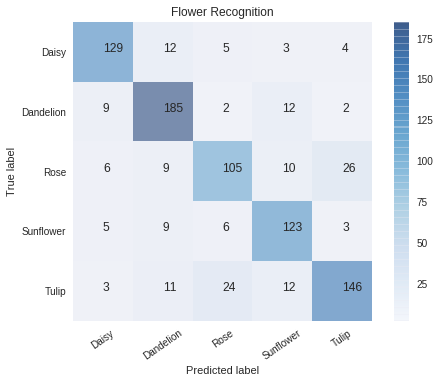

VGG16
------------------------
Confusion Matrix
Classifications
             precision    recall  f1-score   support

      Daisy       0.93      0.93      0.93       153
  Dandelion       0.91      0.92      0.92       210
       Rose       0.91      0.79      0.85       156
  Sunflower       0.89      0.92      0.91       146
      Tulip       0.87      0.92      0.90       196

avg / total       0.90      0.90      0.90       861



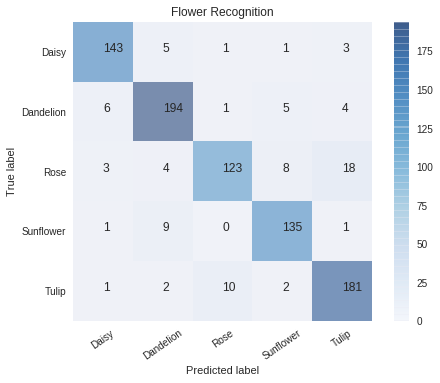

DenseNet121
------------------------
Confusion Matrix
Classifications
             precision    recall  f1-score   support

      Daisy       0.93      0.91      0.92       153
  Dandelion       0.94      0.91      0.92       210
       Rose       0.91      0.72      0.81       156
  Sunflower       0.84      0.95      0.89       146
      Tulip       0.82      0.91      0.86       196

avg / total       0.89      0.88      0.88       861



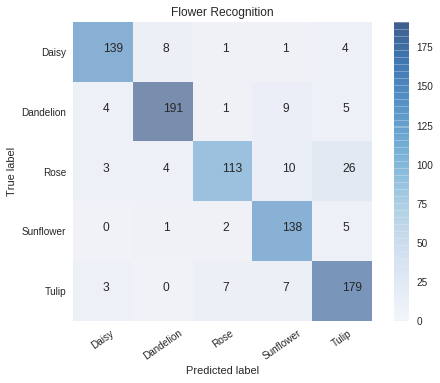

In [63]:
print("Scratch")
print("------------------------")
y_pred = []
y_true = []
for batch in range(len(valid_gen)):
  y_img_batch, y_class_batch = valid_gen[batch] 
  y_pred_t = np.argmax(model.predict(y_img_batch),-1)
  y_true_t = np.argmax(y_class_batch,-1)
  y_pred.append(y_pred_t)
  y_true.append(y_true_t)

y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)

print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)
print('Classifications')
classNames = ['Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip']
print(classification_report(y_true, y_pred, target_names=classNames))
plt.clf()
plt.imshow(cm, interpolation='nearest', alpha=0.5, cmap=plt.cm.Blues)
plt.title('Flower Recognition')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=35)
plt.yticks(tick_marks, classNames)
for i in range(5):
    for j in range(5):
        plt.text(j,i, str(cm[i][j]))
plt.grid(False)
plt.colorbar()
plt.show()


print("VGG16")
print("------------------------")
y_pred = []
y_true = []
for batch in range(len(valid_gen)):
  y_img_batch, y_class_batch = valid_gen[batch] 
  y_pred_t = np.argmax(model2.predict(y_img_batch),-1)
  y_true_t = np.argmax(y_class_batch,-1)
  y_pred.append(y_pred_t)
  y_true.append(y_true_t)

y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)

print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)
print('Classifications')
classNames = ['Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip']
print(classification_report(y_true, y_pred, target_names=classNames))
plt.clf()
plt.imshow(cm, interpolation='nearest', alpha=0.5, cmap=plt.cm.Blues)
plt.title('Flower Recognition')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=35)
plt.yticks(tick_marks, classNames)
for i in range(5):
    for j in range(5):
        plt.text(j,i, str(cm[i][j]))
plt.grid(False)
plt.colorbar()
plt.show()


print("DenseNet121")
print("------------------------")
y_pred = []
y_true = []
for batch in range(len(valid_gen)):
  y_img_batch, y_class_batch = valid_gen[batch] 
  y_pred_t = np.argmax(model3.predict(y_img_batch),-1)
  y_true_t = np.argmax(y_class_batch,-1)
  y_pred.append(y_pred_t)
  y_true.append(y_true_t)

y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)

print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)
print('Classifications')
classNames = ['Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip']
print(classification_report(y_true, y_pred, target_names=classNames))
plt.clf()
plt.imshow(cm, interpolation='nearest', alpha=0.5, cmap=plt.cm.Blues)
plt.title('Flower Recognition')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=35)
plt.yticks(tick_marks, classNames)
for i in range(5):
    for j in range(5):
        plt.text(j,i, str(cm[i][j]))
plt.grid(False)
plt.colorbar()
plt.show()

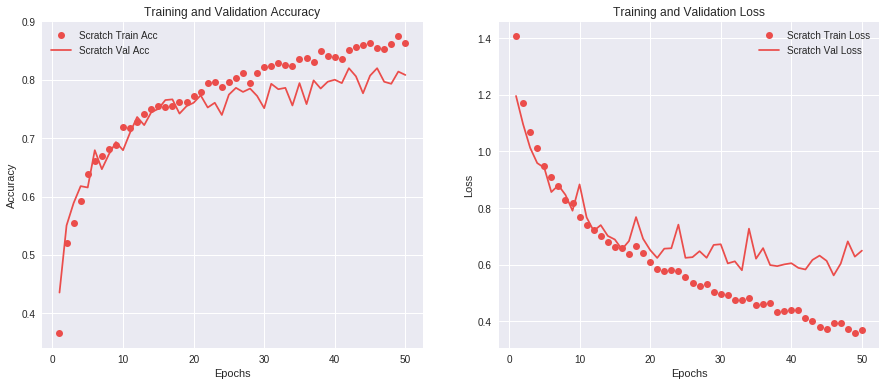

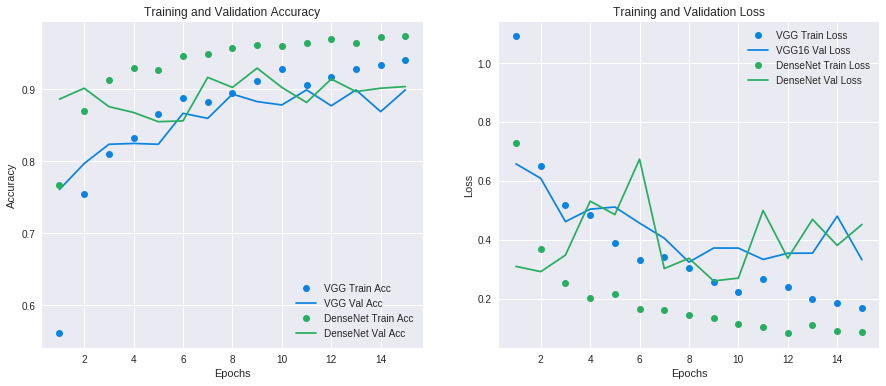

In [64]:
# Scratch
acc = model_hist.history['acc']
val_acc = model_hist.history['val_acc']
loss = model_hist.history['loss']
val_loss = model_hist.history['val_loss']

# VGG16 Model
acc2 = model_hist2.history['acc']
val_acc2 = model_hist2.history['val_acc']
loss2 = model_hist2.history['loss']
val_loss2 = model_hist2.history['val_loss']

# DenseNet Model
acc3 = model_hist3.history['acc']
val_acc3 = model_hist3.history['val_acc']
loss3 = model_hist3.history['loss']
val_loss3 = model_hist3.history['val_loss']

epochs_s = range(1, len(acc) + 1)
epochs = range(1, len(acc2)+1)

plt.figure(figsize=(15, 6));
plt.subplot(1,2,1)
plt.plot(epochs_s, acc, color='#eb4d4b', marker='o', linestyle='none' , label='Scratch Train Acc')
plt.plot(epochs_s, val_acc, color='#eb4d4b',label='Scratch Val Acc')
plt.title('Training and Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_s, loss, color='#eb4d4b', marker='o', linestyle='none',label='Scratch Train Loss')
plt.plot(epochs_s, val_loss, color='#eb4d4b',label='Scratch Val Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()


plt.figure(figsize=(15, 6));
plt.subplot(1,2,1)
plt.plot(epochs, acc2, color='#0984e3', marker='o', linestyle='none' , label='VGG Train Acc')
plt.plot(epochs, val_acc2, color='#0984e3',label='VGG Val Acc')
plt.plot(epochs, acc3, color='#27ae60', marker='o', linestyle='none' , label='DenseNet Train Acc')
plt.plot(epochs, val_acc3, color='#27ae60',label='DenseNet Val Acc')
plt.title('Training and Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs, loss2, color='#0984e3', marker='o', linestyle='none',label='VGG Train Loss')
plt.plot(epochs, val_loss2, color='#0984e3',label='VGG16 Val Loss')
plt.plot(epochs, loss3, color='#27ae60', marker='o', linestyle='none',label='DenseNet Train Loss')
plt.plot(epochs, val_loss3, color='#27ae60',label='DenseNet Val Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [0]:
# Grad CAM - Heatmap

num_images_print = 20
np.random.seed(89)

conv_scr = 'conv2d_5' # scratch
conv_vgg = 'block5_conv3' # VGG16
conv_dense ='conv5_block16_1_conv' # DenseNet

conv_scr_size = 250
conv_vgg_size = 500
conv_dense_size = 125

for xx in range(num_images_print):

  det_flow_type = np.random.randint(5)
  image_num = np.random.randint(200)

  # Grab Random Image
  if det_flow_type == 0:
    flow_image = Path("flowers/tulip")
    flow_type = "Tulip"
  if det_flow_type == 1:
    flow_image = Path("flowers/sunflower")
    flow_type = "Sunflower"
  if det_flow_type == 2:
    flow_image = Path("flowers/daisy")
    flow_type = "Daisy"
  if det_flow_type == 3:
    flow_image = Path("flowers/rose")
    flow_type = "Rose"
  if det_flow_type == 4:
    flow_image = Path("flowers/dandelion")
    flow_type = "Dandelion"
    
  # Load Image and process for prediction  
  image = os.listdir(flow_image)
  load_path = flow_image / image[image_num]
  img = load_img(load_path, target_size=(img_size, img_size))
  img_tensor = img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  x = preprocess_input(img_tensor)
  img = cv2.imread(str(load_path))
  
  # Model Predictions
  scr_preds = model.predict(x)
  vgg_preds = model2.predict(x)
  dense_preds = model3.predict(x)
  
  # Grab final prediction from max results
  scr_t = np.argmax(scr_preds[0])
  vgg_t = np.argmax(vgg_preds[0])
  dense_t = np.argmax(dense_preds[0])
    
  # Grab predicted layer from model output
  flower_layer_scr = model.output[:,scr_t]
  flower_layer_vgg = model2.output[:,vgg_t]
  flower_layer_dense = model3.output[:,dense_t]

  # Output feature map
  scr_last_conv_layer = model.get_layer(conv_scr)
  vgg_last_conv_layer = model2.get_layer(conv_vgg)
  dense_last_conv_layer = model3.get_layer(conv_dense)

  # Find gradients
  scr_grads = K.gradients(flower_layer_scr, scr_last_conv_layer.output)[0]
  vgg_grads = K.gradients(flower_layer_vgg, vgg_last_conv_layer.output)[0]
  dense_grads = K.gradients(flower_layer_dense, dense_last_conv_layer.output)[0]

  # Pooled gradients
  scr_pooled_grads = K.mean(scr_grads, axis=(0, 1, 2))
  vgg_pooled_grads = K.mean(vgg_grads, axis=(0, 1, 2))
  dense_pooled_grads = K.mean(dense_grads, axis=(0, 1, 2))

  # Obtain and save each heatmap for each model
  # Scratch
  iterate = K.function([model.input],[scr_pooled_grads, scr_last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(conv_scr_size):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  cv2.imwrite('colormap_scratch.jpg', heatmap)

  # VGG
  iterate = K.function([model2.input],[vgg_pooled_grads, vgg_last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(conv_vgg_size):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  cv2.imwrite('colormap_vgg.jpg', heatmap)

  # Dense
  iterate = K.function([model3.input],[dense_pooled_grads, dense_last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(conv_dense_size):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  cv2.imwrite('colormap_dense.jpg', heatmap)

  # Open each heatmap
  colormap_scr = cv2.imread('colormap_scratch.jpg')
  colormap_vgg = cv2.imread('colormap_vgg.jpg')
  colormap_dense = cv2.imread('colormap_dense.jpg')

  # Superimpose on each image
  fig = plt.figure(xx, figsize=(25, 25))
  
  # Scratch
  ax1 = fig.add_subplot(1,3,1)
  ax1 = plt.imshow(cv2.cvtColor(colormap_scr, cv2.COLOR_BGR2RGB))
  ax1 = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), alpha=0.5)
  ax1 = plt.grid(None)
  ax1 = plt.axis('off')
  ax1 = plt.title('Scratch')

  # VGG
  ax2 = fig.add_subplot(1,3,2)
  ax2 = plt.imshow(cv2.cvtColor(colormap_vgg, cv2.COLOR_BGR2RGB))
  ax2 = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), alpha=0.5)
  ax2 = plt.grid(None)
  ax2 = plt.axis('off')
  ax2 = plt.title('VGG16')
  
  # Dense
  ax3 = fig.add_subplot(1,3,3)
  ax3 = plt.imshow(cv2.cvtColor(colormap_dense, cv2.COLOR_BGR2RGB))
  ax3 = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), alpha=0.5)
  ax3 = plt.grid(None)
  ax3 = plt.axis('off')
  ax3 = plt.title('DenseNet121')

  plt.show()
